<a href="https://colab.research.google.com/github/Kolarov22/NeuralNetworks/blob/main/Brain_Tumor_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'brain-tumor-mri-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1608934%2F2645886%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240522%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240522T210832Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D139b2921e2ac13bb3a10f4e2df6719370b023228ab68cda3ac807aea5954c53c25fee585a64535300ec004a513216dbe61736a75aa8c0da27adf4a5d4f275cb4dd66d6cefd24332d531d5e6916d7970d52236896d0510a9e9defb5a4fd1189d890911cae7235212947ea858ad7c78d6f63f7dc5e90207b539633899bad4ae965821bbb313c0eb914f5ee6c86f45a4374bc44e4ece6a854c7aa048dc77cb90bf5f8bfc16ccec3facdc85dcfdce97a5aabe6fc68dc65c013aa6fc0f582ea0f38891e019107f012dfab97aa63652a5c1c4067e259b055b544e0beb1843d6ce1fff77cfc6c0074bbaf48cb6c435198af0ffa4fc2d6af535466a0f2a004321c660f2d'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 155791278 bytes downloaded
Downloaded and uncompressed: brain-tumor-mri-dataset
Data source import complete.


In [ ]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('check')

check


# Data Preprocessing



**store the data into data frames**

In [ ]:
# Generate data paths with labels
train_data_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
filepaths = []
labels = []

folds = os.listdir(train_data_dir)
for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
train_df = pd.concat([Fseries, Lseries], axis= 1)

In [ ]:
# Generate data paths with labels
test_data_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'
filepaths = []
labels = []

folds = os.listdir(test_data_dir)
for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
ts_df = pd.concat([Fseries, Lseries], axis= 1)

In [ ]:
train_df

,filepaths,labels
0,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
...,...,...
5707,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5708,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5709,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5710,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma


In [ ]:
ts_df

,filepaths,labels
0,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
...,...,...
1306,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1307,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1308,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1309,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma


Split dataframe into train, valid, and test (we see that data is already splitted into train and test)


In [ ]:
valid_df, test_df = train_test_split(ts_df,  train_size= 0.5, shuffle= True, random_state= 123)

Create image data generator


In [ ]:
# cropping images
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


Show sample from train data


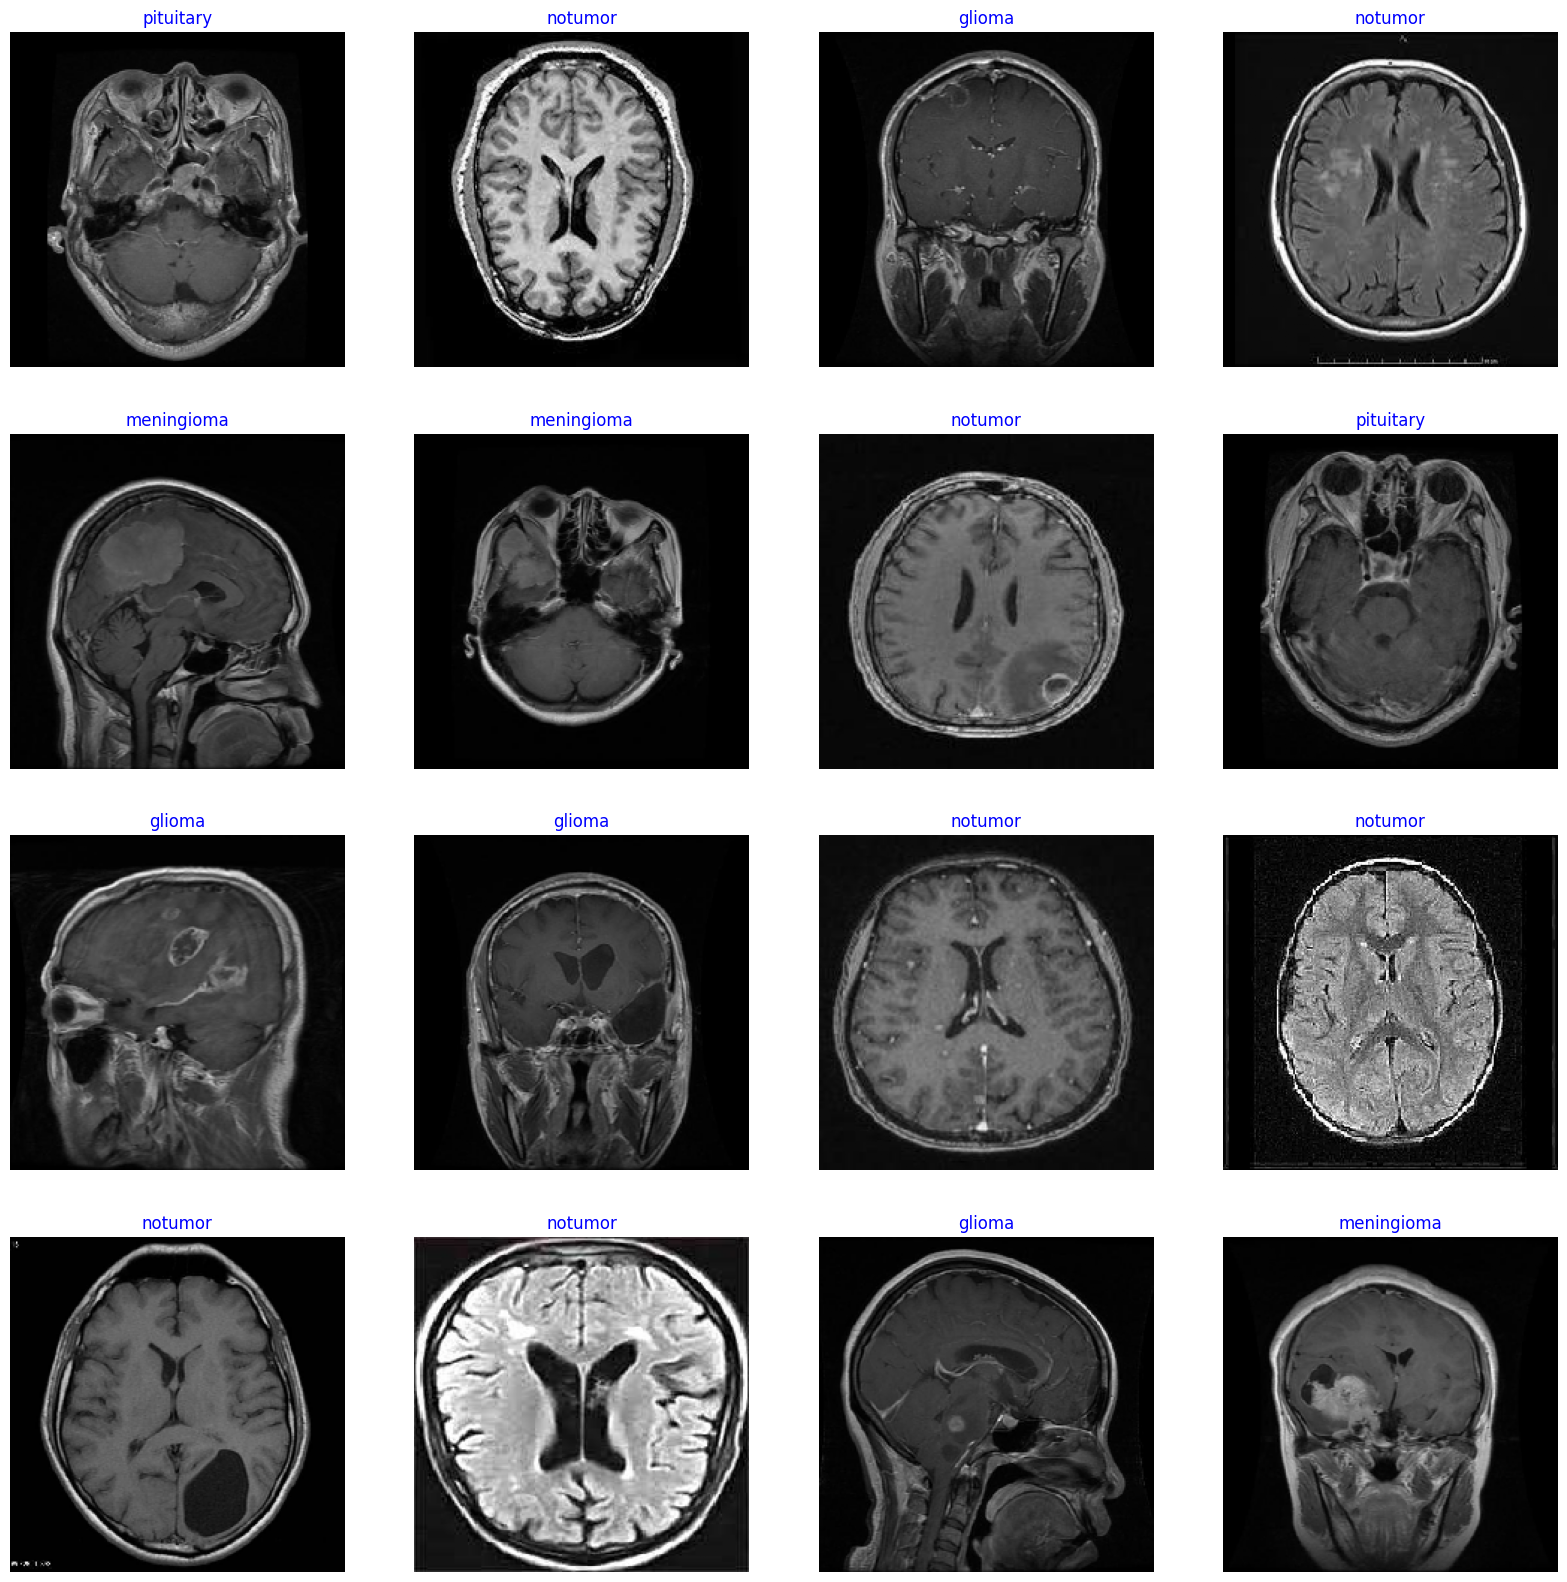

In [ ]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's keys (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

# model structure


In [ ]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = 4
model =Sequential ([
    Conv2D(filters=64,kernel_size=(3,3),activation="relu",input_shape=img_shape),
    Conv2D(filters=64,kernel_size=(3,3),activation="relu"),
    MaxPooling2D((2,2)),

    Conv2D(filters=128,kernel_size=(3,3),activation="relu"),
    Conv2D(filters=128,kernel_size=(3,3),activation="relu"),
    MaxPooling2D((2,2)),


    Conv2D(filters=256,kernel_size=(3,3),activation="relu"),
    Conv2D(filters=256,kernel_size=(3,3),activation="relu"),
    Conv2D(filters=256,kernel_size=(3,3),activation="relu"),
    MaxPooling2D((2,2)),

    Conv2D(filters=512,kernel_size=(3,3),activation="relu"),
    Conv2D(filters=512,kernel_size=(3,3),activation="relu"),
    Conv2D(filters=512,kernel_size=(3,3),activation="relu"),
    MaxPooling2D((2,2)),

    Conv2D(filters=512,kernel_size=(3,3),activation="relu"),
    Conv2D(filters=512,kernel_size=(3,3),activation="relu"),
    Conv2D(filters=512,kernel_size=(3,3),activation="relu"),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(256,activation="relu"),

    Dense(128,activation="relu"),
    Dense(4,activation="softmax")
])
model.compile (Adamax(learning_rate=0.001),loss='categorical_crossentropy', metrics=["accuracy"])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 conv2d_14 (Conv2D)          (None, 220, 220, 64)      36928     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 110, 110, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 108, 108, 128)     73856     
                                                                 
 conv2d_16 (Conv2D)          (None, 106, 106, 128)     147584    
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 53, 53, 128)       0         
 g2D)                                                 

# training the model


In [ ]:
epochs = 10   # number of all epochs in training

history = model.fit(train_gen , epochs= epochs , verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/10
357/357 [==============================] - 76s 201ms/step - loss: 1.2012 - accuracy: 0.4902 - val_loss: 0.8144 - val_accuracy: 0.6672
Epoch 2/10
357/357 [==============================] - 71s 198ms/step - loss: 0.6311 - accuracy: 0.7435 - val_loss: 0.6601 - val_accuracy: 0.7450
Epoch 3/10
357/357 [==============================] - 71s 199ms/step - loss: 0.4948 - accuracy: 0.8065 - val_loss: 0.7433 - val_accuracy: 0.6901
Epoch 4/10
357/357 [==============================] - 71s 199ms/step - loss: 0.3938 - accuracy: 0.8521 - val_loss: 0.5256 - val_accuracy: 0.7954
Epoch 5/10
357/357 [==============================] - 71s 198ms/step - loss: 0.2945 - accuracy: 0.8890 - val_loss: 0.4236 - val_accuracy: 0.8366
Epoch 6/10
357/357 [==============================] - 71s 199ms/step - loss: 0.2614 - accuracy: 0.9034 - val_loss: 0.3340 - val_accuracy: 0.8855
Epoch 7/10
357/357 [==============================] - 71s 198ms/step - loss: 0.1947 - accuracy: 0.9333 - val_loss: 0.2009 - val_ac

# model performance

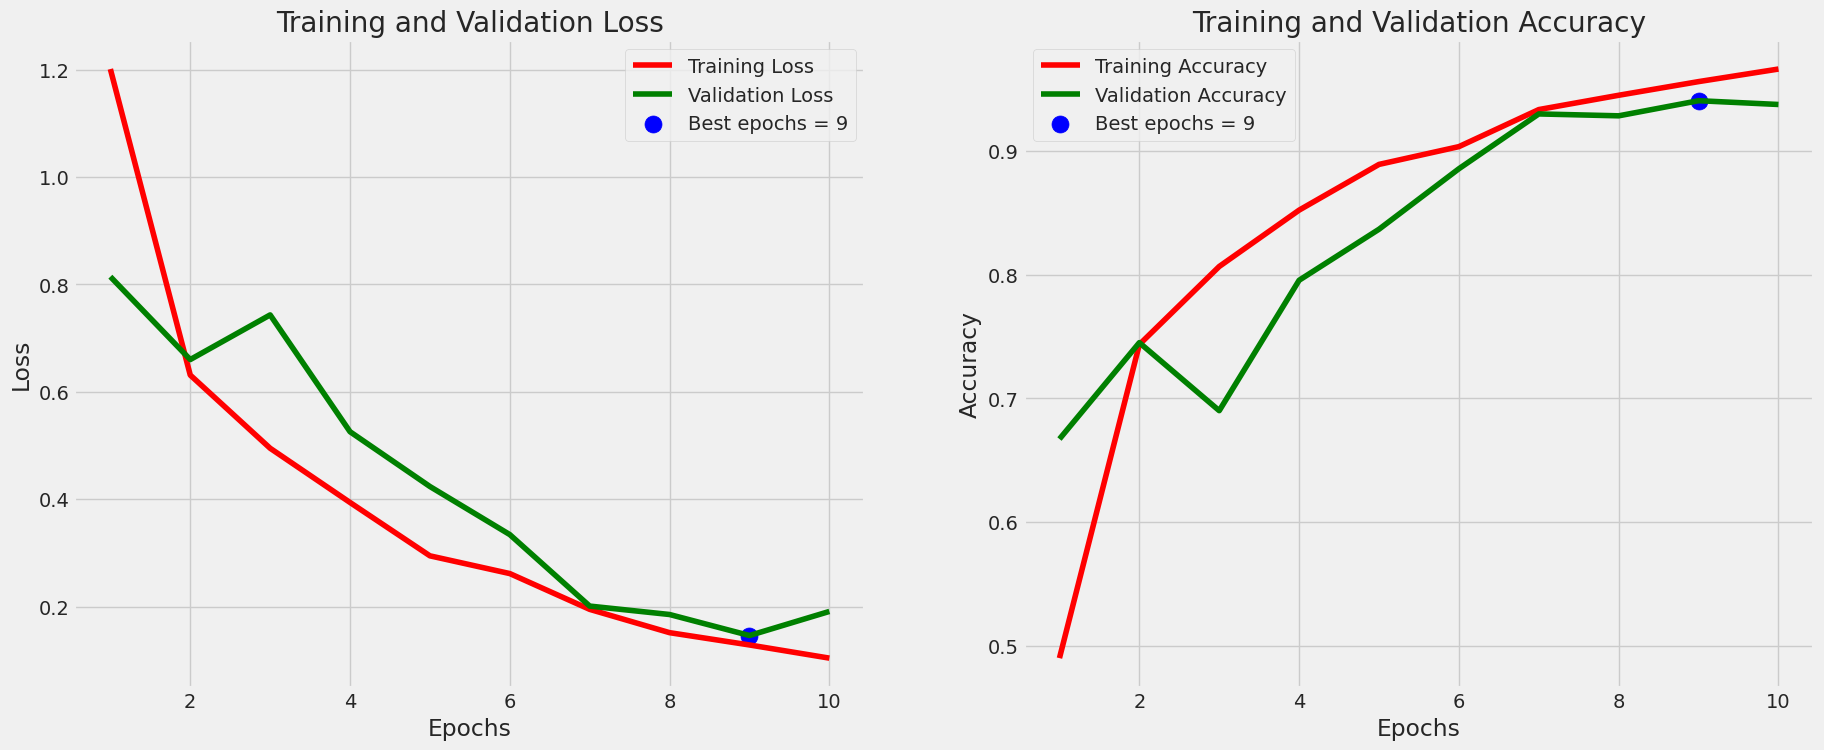

In [ ]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue',label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'blue',label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show();


# model evaluation

In [ ]:
train_score = model.evaluate(train_gen , steps =16 , verbose = 1)
valid_score = model.evaluate(valid_gen , steps = 16 , verbose = 1)
test_score = model.evaluate(test_gen , steps = 16 , verbose = 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

16/16 [==============================] - 1s 58ms/step - loss: 0.0826 - accuracy: 0.9688
Train Loss:  0.1385042518377304
Train Accuracy:  0.9453125
--------------------
Validation Loss:  0.23815634846687317
Validation Accuracy:  0.921875
--------------------
Test Loss:  0.08264096081256866
Test Accuracy:  0.96875


# model prediction

In [ ]:
preds = model.predict(test_gen)

y_pred = np.argmax(preds , axis = 1)

41/41 [==============================] - 2s 56ms/step


In [ ]:
preds


array([[3.41959412e-06, 3.46034416e-03, 9.96534944e-01, 1.34810955e-06],
       [1.16909616e-01, 6.35353625e-01, 2.36960322e-01, 1.07764611e-02],
       [9.99999404e-01, 4.72875939e-07, 1.19668996e-07, 4.51771420e-08],
       ...,
       [2.69165099e-01, 1.86610129e-02, 1.81470960e-01, 5.30702949e-01],
       [2.53414291e-05, 2.61286514e-05, 3.84396808e-05, 9.99910116e-01],
       [4.01486382e-02, 8.94943595e-01, 6.47538677e-02, 1.53826637e-04]],
      dtype=float32)

# confusion matrix

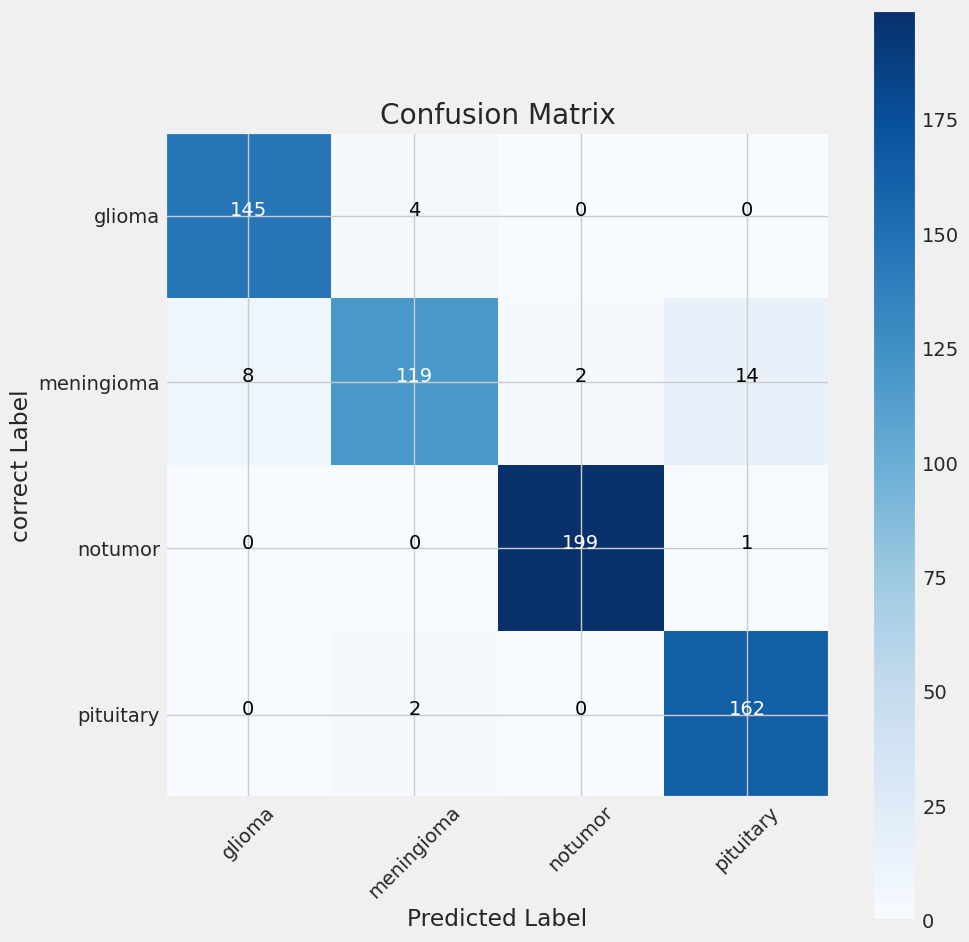

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('correct Label')
plt.xlabel('Predicted Label')

plt.show()

# classification report

In [ ]:
print(classification_report(test_gen.classes, y_pred , target_names= classes ))

              precision    recall  f1-score   support

      glioma       0.95      0.97      0.96       149
  meningioma       0.95      0.83      0.89       143
     notumor       0.99      0.99      0.99       200
   pituitary       0.92      0.99      0.95       164

    accuracy                           0.95       656
   macro avg       0.95      0.95      0.95       656
weighted avg       0.95      0.95      0.95       656

